Using device: cuda
Text length: 1115394 characters

Training with sequence length: 30
Epoch 1, Train Loss: 2.5127, Train Acc: 0.2619, Val Loss: 2.4846, Val Acc: 0.2569
Epoch 2, Train Loss: 2.4822, Train Acc: 0.2654, Val Loss: 2.4737, Val Acc: 0.2686
Epoch 3, Train Loss: 2.4777, Train Acc: 0.2664, Val Loss: 2.4688, Val Acc: 0.2714
Epoch 4, Train Loss: 2.4748, Train Acc: 0.2672, Val Loss: 2.4684, Val Acc: 0.2700
Epoch 5, Train Loss: 2.4728, Train Acc: 0.2676, Val Loss: 2.4696, Val Acc: 0.2651
Epoch 6, Train Loss: 2.4714, Train Acc: 0.2679, Val Loss: 2.4658, Val Acc: 0.2676
Epoch 7, Train Loss: 2.4701, Train Acc: 0.2680, Val Loss: 2.4670, Val Acc: 0.2706
Epoch 8, Train Loss: 2.4692, Train Acc: 0.2686, Val Loss: 2.4640, Val Acc: 0.2708
Epoch 9, Train Loss: 2.4684, Train Acc: 0.2682, Val Loss: 2.4661, Val Acc: 0.2676
Epoch 10, Train Loss: 2.4678, Train Acc: 0.2686, Val Loss: 2.4659, Val Acc: 0.2703
Epoch 11, Train Loss: 2.4671, Train Acc: 0.2690, Val Loss: 2.4630, Val Acc: 0.2700
Epoch 12, 

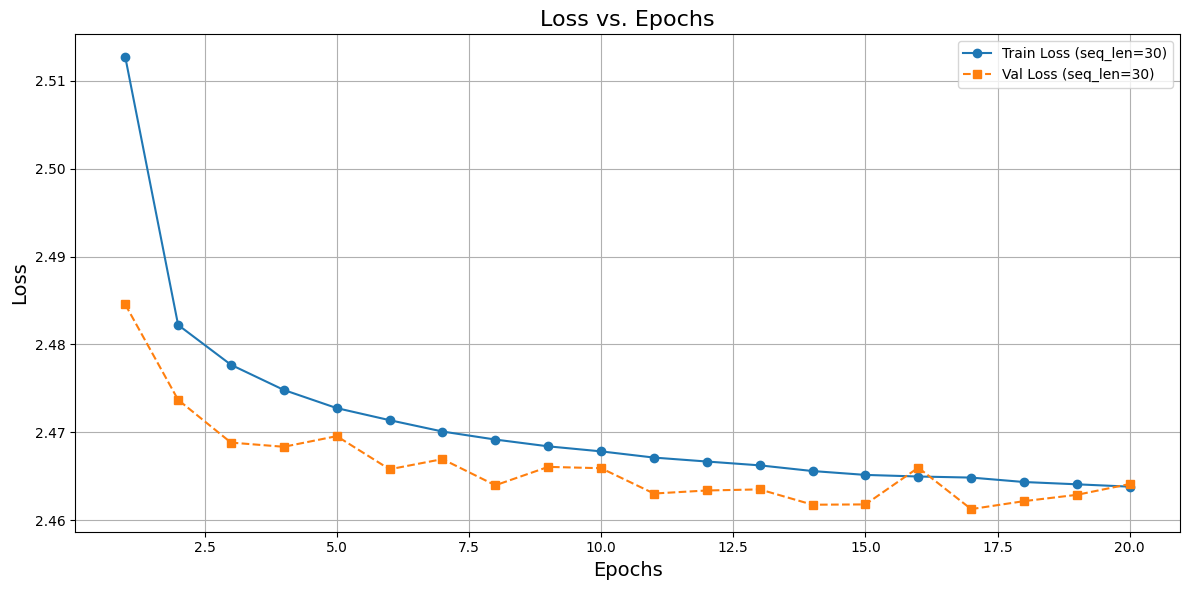

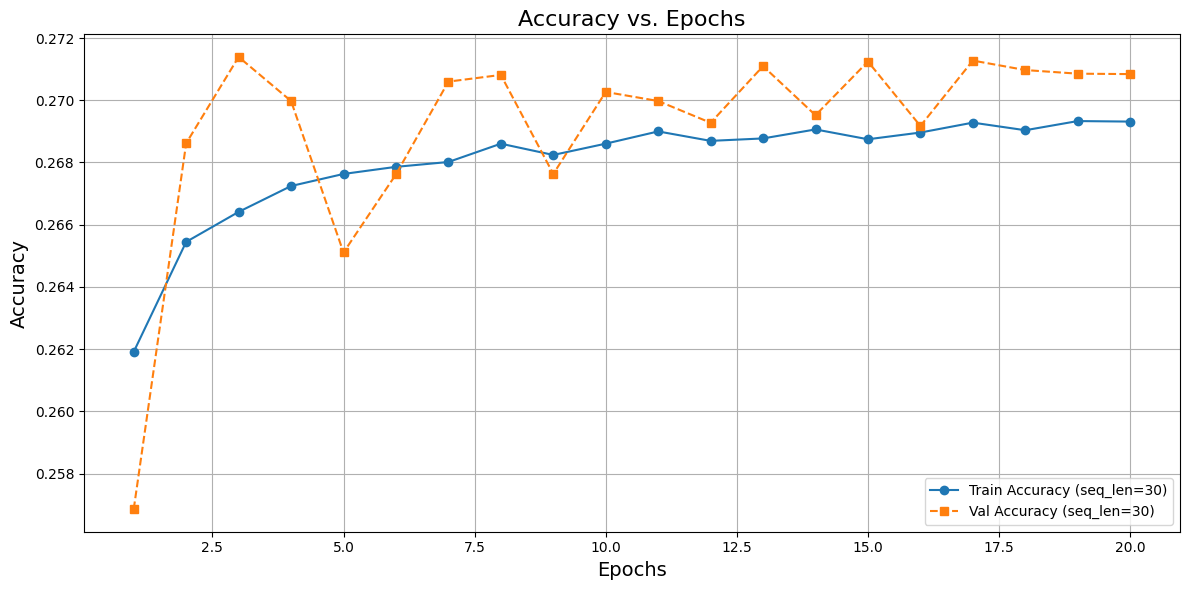

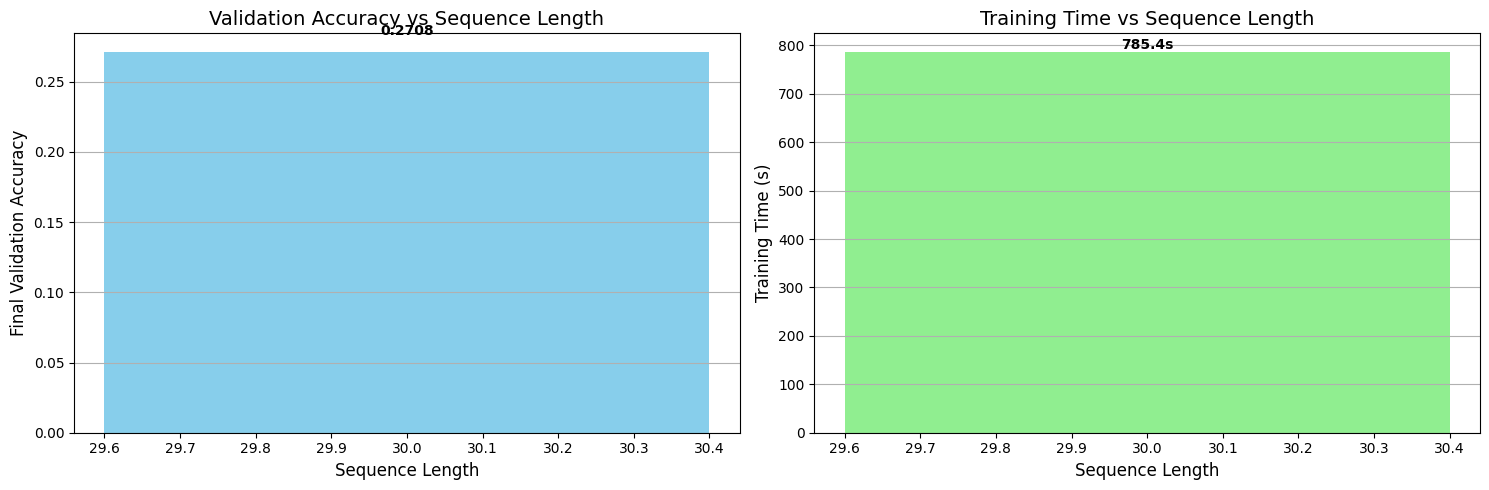


Experiment Summary:
Sequence Length 30: Accuracy = 0.2708, Time = 785.40s


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import requests
import time
import matplotlib.pyplot as plt
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def load_shakespeare_data():
    """Download the Shakespeare dataset"""
    url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
    response = requests.get(url)
    return response.text

def prepare_data(text, sequence_length):
    """Prepare dataset with the specified sequence length"""
    # Truncate text to fit sequence length
    text = text[:sequence_length * (len(text)//sequence_length)]

    # Create character mappings
    chars = sorted(list(set(text)))
    char_to_int = {ch: i for i, ch in enumerate(chars)}
    int_to_char = {i: ch for i, ch in enumerate(chars)}

    # Encode text
    encoded_text = [char_to_int[ch] for ch in text]

    # Create sequences and targets
    sequences = []
    targets = []
    for i in range(0, len(encoded_text) - sequence_length):
        seq = encoded_text[i:i+sequence_length]
        target = encoded_text[i+sequence_length]
        sequences.append(seq)
        targets.append(target)

    # Convert to tensors
    sequences = torch.tensor(sequences, dtype=torch.long)
    targets = torch.tensor(targets, dtype=torch.long)

    return sequences, targets, chars, char_to_int, int_to_char

class CharDataset(Dataset):
    """Character-level dataset"""
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        return self.sequences[index], self.targets[index]

class CharModel(nn.Module):
    """Character-level language model using a Transformer architecture"""
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, num_heads=2, dim_feedforward=256, dropout=0.1):
        super(CharModel, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size,
            nhead=num_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        transformer_output = self.transformer_encoder(embedded)
        output = self.fc(transformer_output[:, -1, :])
        return output

def create_dataloaders(sequences, targets, batch_size=128):
    """Create train and test dataloaders"""
    dataset = CharDataset(sequences, targets)

    train_size = int(len(dataset) * 0.8)
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

    return train_loader, test_loader

def train_evaluate(model, train_loader, val_loader, epochs, device, learning_rate=0.0001):
    """Train and evaluate a model, returning metrics history"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # For tracking metrics
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': [],
        'train_accuracy': []
    }

    start_time = time.time()

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

            # Calculate training accuracy
            _, predicted = torch.max(output, 1)
            train_total += targets.size(0)
            train_correct += (predicted == targets).sum().item()

        epoch_train_loss = train_loss / len(train_loader.dataset)
        epoch_train_accuracy = train_correct / train_total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                val_output = model(inputs)
                loss = criterion(val_output, targets)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(val_output, 1)
                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_accuracy = val_correct / val_total

        # Store metrics
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_accuracy'].append(epoch_train_accuracy)
        history['val_accuracy'].append(epoch_val_accuracy)

        print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f}, '
              f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.4f}')

    execution_time = time.time() - start_time
    print(f"Training completed in {execution_time:.2f} seconds")

    return history, execution_time

def plot_loss_vs_epochs(all_metrics, sequence_lengths):
    """Plot loss vs epochs for different sequence lengths"""
    plt.figure(figsize=(12, 6))

    # Plot training loss
    for seq_len in sequence_lengths:
        epochs = range(1, len(all_metrics[seq_len]['train_loss']) + 1)
        plt.plot(epochs, all_metrics[seq_len]['train_loss'],
                 marker='o', linestyle='-',
                 label=f'Train Loss (seq_len={seq_len})')

    # Plot validation loss
    for seq_len in sequence_lengths:
        epochs = range(1, len(all_metrics[seq_len]['val_loss']) + 1)
        plt.plot(epochs, all_metrics[seq_len]['val_loss'],
                 marker='s', linestyle='--',
                 label=f'Val Loss (seq_len={seq_len})')

    plt.title('Loss vs. Epochs', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.grid(True)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig('loss_vs_epochs.png')
    plt.show()

def plot_accuracy_vs_epochs(all_metrics, sequence_lengths):
    """Plot accuracy vs epochs for different sequence lengths"""
    plt.figure(figsize=(12, 6))

    # Plot training accuracy
    for seq_len in sequence_lengths:
        epochs = range(1, len(all_metrics[seq_len]['train_accuracy']) + 1)
        plt.plot(epochs, all_metrics[seq_len]['train_accuracy'],
                 marker='o', linestyle='-',
                 label=f'Train Accuracy (seq_len={seq_len})')

    # Plot validation accuracy
    for seq_len in sequence_lengths:
        epochs = range(1, len(all_metrics[seq_len]['val_accuracy']) + 1)
        plt.plot(epochs, all_metrics[seq_len]['val_accuracy'],
                 marker='s', linestyle='--',
                 label=f'Val Accuracy (seq_len={seq_len})')

    plt.title('Accuracy vs. Epochs', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.grid(True)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig('accuracy_vs_epochs.png')
    plt.show()

def plot_comparison(sequence_lengths, val_accuracies, train_times):
    """Plot comparison of sequence lengths vs. validation accuracy and training time"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.bar(sequence_lengths, val_accuracies, color='skyblue')
    ax1.set_xlabel('Sequence Length', fontsize=12)
    ax1.set_ylabel('Final Validation Accuracy', fontsize=12)
    ax1.set_title('Validation Accuracy vs Sequence Length', fontsize=14)
    ax1.grid(True, axis='y')

    # Add values on top of the bars
    for i, v in enumerate(val_accuracies):
        ax1.text(sequence_lengths[i], v + 0.01, f'{v:.4f}',
                 ha='center', va='bottom', fontweight='bold')

    ax2.bar(sequence_lengths, train_times, color='lightgreen')
    ax2.set_xlabel('Sequence Length', fontsize=12)
    ax2.set_ylabel('Training Time (s)', fontsize=12)
    ax2.set_title('Training Time vs Sequence Length', fontsize=14)
    ax2.grid(True, axis='y')

    # Add values on top of the bars
    for i, v in enumerate(train_times):
        ax2.text(sequence_lengths[i], v + 1, f'{v:.1f}s',
                 ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.savefig('sequence_length_comparison.png')
    plt.show()

def run_experiment(sequence_lengths, epochs=3):
    """Run experiment for multiple sequence lengths"""
    # Get the text data once
    text = load_shakespeare_data()
    print(f"Text length: {len(text)} characters")

    # Parameters
    hidden_size = 512
    num_layers = 1
    num_heads = 4
    dim_feedforward = 256
    dropout = 0.1
    learning_rate = 0.0001
    batch_size = 128

    all_metrics = {}
    final_val_accuracies = []
    training_times = []

    for seq_len in sequence_lengths:
        print(f"\n{'='*50}")
        print(f"Training with sequence length: {seq_len}")
        print(f"{'='*50}")

        # Prepare data for this sequence length
        sequences, targets, chars, char_to_int, int_to_char = prepare_data(text, seq_len)
        train_loader, test_loader = create_dataloaders(sequences, targets, batch_size)

        # Create and initialize the model
        model = CharModel(
            input_size=len(chars),
            hidden_size=hidden_size,
            output_size=len(chars),
            num_layers=num_layers,
            num_heads=num_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout
        ).to(device)

        # Train the model
        history, exec_time = train_evaluate(
            model=model,
            train_loader=train_loader,
            val_loader=test_loader,
            epochs=epochs,
            device=device,
            learning_rate=learning_rate
        )

        # Store results
        all_metrics[seq_len] = history
        final_val_accuracies.append(history['val_accuracy'][-1])
        training_times.append(exec_time)

        print(f"\nResults for sequence length {seq_len}:")
        print(f"Final Training Loss: {history['train_loss'][-1]:.4f}")
        print(f"Final Validation Loss: {history['val_loss'][-1]:.4f}")
        print(f"Final Training Accuracy: {history['train_accuracy'][-1]:.4f}")
        print(f"Final Validation Accuracy: {history['val_accuracy'][-1]:.4f}")
        print(f"Training Time: {exec_time:.2f} seconds")

    # Plot the results with separate plots for loss and accuracy
    plot_loss_vs_epochs(all_metrics, sequence_lengths)
    plot_accuracy_vs_epochs(all_metrics, sequence_lengths)
    plot_comparison(sequence_lengths, final_val_accuracies, training_times)

    return all_metrics, final_val_accuracies, training_times

if __name__ == "__main__":
    # Define sequence lengths to experiment with
    sequence_lengths = [20, 30, 50]
    #sequence_lengths = [30]
    # Number of layers and sequence lengths are adjusted to achieve results, ran into memory and token issues with colab when trying to run too much at one time.


    # Run the experiment
    metrics, accuracies, times = run_experiment(sequence_lengths, epochs=20)

    # Print summary
    print("\nExperiment Summary:")
    for i, seq_len in enumerate(sequence_lengths):
        print(f"Sequence Length {seq_len}: Accuracy = {accuracies[i]:.4f}, Time = {times[i]:.2f}s")